In [48]:
from __future__ import print_function
from collections import defaultdict
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from math import *
%matplotlib inline

In [76]:
class JacksCarRental():
    def __init__(self,
                 MAX_CARS = 20,
                 MAX_MOVE_OF_CARS = 5,
                 RENTAL_REQUEST_FIRST_LOC = 3,
                 RENTAL_REQUEST_SECOND_LOC = 4,
                 RETURNS_FIRST_LOC = 3,
                 RETURNS_SECOND_LOC = 2,
                 DISCOUNT = 0.9,
                 RENTAL_CREDIT = 10,
                 MOVE_CAR_COST = 2,
                 POISSON_UP_BOUND = 11,
                 constantReturnedCars = True,
                 discount_factor=0.9,
                 delta=1e-4,
                 max_move_cars=5,
                 max_num_cars=20,
                 max_rentals=11,
                 max_returns=11,
                 rental_credit=10,
                 request_param_1=3,
                 request_param_2=4,
                 return_param_1=3,
                 return_param_2=2,
                 cost_to_tow=2,
                 extra_storage_fee=0,
                 constant_returned_cars=True
                ):

        # maximum # of cars in each location
        self.MAX_CARS = MAX_CARS
        self.max_num_cars = max_num_cars

        # maximum # of cars to move during night
        self.MAX_MOVE_OF_CARS = 5
        self.max_move_cars = max_move_cars

        # expectation for rental requests in first location
        self.RENTAL_REQUEST_FIRST_LOC = 3

        # expectation for rental requests in second location
        self.RENTAL_REQUEST_SECOND_LOC = 4

        # return cars
        self.constantReturnedCars = constantReturnedCars
        
        # expectation for # of cars returned in first location
        self.RETURNS_FIRST_LOC = 3

        # expectation for # of cars returned in second location
        self.RETURNS_SECOND_LOC = 2

        self.DISCOUNT = 0.9

        # credit earned by a car
        self.RENTAL_CREDIT = 10

        # cost of moving a car
        self.MOVE_CAR_COST = 2
        self.cost_to_tow = 2

        # current policy
        self.policy = np.zeros((self.MAX_CARS + 1, self.MAX_CARS + 1))
        self.policy_index = 0
        self.policies = {self.policy_index: self.policy}
    
        # current state value
        self.stateValue = np.zeros((self.MAX_CARS + 1, self.MAX_CARS + 1))

        # all possible states
        self.states = []

        # all possible actions
        self.actions = np.arange(-MAX_MOVE_OF_CARS, MAX_MOVE_OF_CARS + 1)
        
        self.POISSON_UP_BOUND = 11
        self.max_rentals = max_rentals
        self.poissonBackup = dict()
        self.figureIndex = 0

        
    # axes for printing use
        self.AxisXPrint = []
        self.AxisYPrint = []
        for i in range(0, self.MAX_CARS + 1):
            for j in range(0, self.MAX_CARS + 1):
                self.AxisXPrint.append(i)
                self.AxisYPrint.append(j)
                self.states.append([i, j])


    # plot a policy/state value matrix
    def prettyPrint(self, data, labels):
        fig = plt.figure(self.figureIndex)
        self.figureIndex += 1
        ax = fig.add_subplot(111, projection='3d')
        AxisZ = []
        for i, j in states:
            AxisZ.append(data[i, j])
        ax.scatter(self.AxisXPrint, self.AxisYPrint, AxisZ)
        ax.set_xlabel(labels[0])
        ax.set_ylabel(labels[1])
        ax.set_zlabel(labels[2])
        
    def plot_policy(self):
        fig = plt.figure(figsize=(6,6))
        ax_image = fig.add_axes([0.1,0.15,0.7,0.7])
        ax_color = fig.add_axes([0.85,0.15,0.05,0.7])
        image = ax_image.imshow(self.policy[::-1,:], 
                                cmap=cm.coolwarm,
                                extent=[0, 20, 0, 20])
        ax_image.set_xticks(np.arange(0,21,2).astype(int))
        ax_image.set_yticks(np.arange(0,21,2).astype(int))
        ax_image.set_xlabel('Number of cars at location 1')
        ax_image.set_ylabel('Number of cars at location 2')
        # ax_image.set_title('Policy at different states. Iteration:'+str(iter_idx))
        image.set_clim(vmin=-5, vmax=5)
        cbar = fig.colorbar(image, cax=ax_color, 
                            ticks=[-5,-4,-3,-2,-1,0,1,2,3,4,5],
                            orientation='vertical')
        plt.show()
        
        
    def plot_figure_4_2(self):
        # plot policies
        for i in range(5):
            ax_image = fig.add_axes([0.1,0.15,0.7,0.7])
            ax_color = fig.add_axes([0.85,0.15,0.05,0.7])
            image = ax_image.imshow(self.policies[i][::-1,:], 
                                    cmap=cm.coolwarm,
                                    extent=[0, 20, 0, 20])
            ax_image.set_xticks(np.arange(0,21,2).astype(int))
            ax_image.set_yticks(np.arange(0,21,2).astype(int))
            ax_image.set_xlabel('Number of cars at location 1')
            ax_image.set_ylabel('Number of cars at location 2')
            ax_image.set_title('Policy '+str(i))
            image.set_clim(vmin=-5, vmax=5)
            cbar = fig.colorbar(image, cax=ax_color, 
                                ticks=[-5,-4,-3,-2,-1,0,1,2,3,4,5],
                                orientation='vertical')
        # plot value function

    def poisson(self, n, lam):
        key = n * 10 + lam
        if key not in self.poissonBackup.keys():
            self.poissonBackup[key] = exp(-lam) * pow(lam, n) / factorial(n)
        return self.poissonBackup[key]

    def cost_to_move(self, action):
        return abs(action) * self.cost_to_tow

    def expectedReturn(self, state, action):
        # initailize total return
        returns = 0.0

        # cost for moving cars
        returns -= self.cost_to_move(action)

        # go through all possible rental requests
        for rentalRequestFirstLoc in range(0, self.POISSON_UP_BOUND):
            for rentalRequestSecondLoc in range(0, self.POISSON_UP_BOUND):
                # moving cars
                numOfCarsFirstLoc = int(min(state[0] - action, self.MAX_CARS))
                numOfCarsSecondLoc = int(min(state[1] + action, self.MAX_CARS))

                # valid rental requests should be less than actual # of cars
                realRentalFirstLoc = min(numOfCarsFirstLoc, rentalRequestFirstLoc)
                realRentalSecondLoc = min(numOfCarsSecondLoc, rentalRequestSecondLoc)

                # get credits for renting
                reward = (realRentalFirstLoc + realRentalSecondLoc) * self.RENTAL_CREDIT
                numOfCarsFirstLoc -= realRentalFirstLoc
                numOfCarsSecondLoc -= realRentalSecondLoc

                # probability for current combination of rental requests
                prob = self.poisson(rentalRequestFirstLoc, self.RENTAL_REQUEST_FIRST_LOC) * \
                             self.poisson(rentalRequestSecondLoc, self.RENTAL_REQUEST_SECOND_LOC)


                if self.constantReturnedCars:
                    # get returned cars, those cars can be used for renting tomorrow
                    returnedCarsFirstLoc = self.RETURNS_FIRST_LOC
                    returnedCarsSecondLoc = self.RETURNS_SECOND_LOC
                    numOfCarsFirstLoc = min(numOfCarsFirstLoc + returnedCarsFirstLoc, self.MAX_CARS)
                    numOfCarsSecondLoc = min(numOfCarsSecondLoc + returnedCarsSecondLoc, self.MAX_CARS)
                    returns += prob * (reward + self.DISCOUNT * self.stateValue[numOfCarsFirstLoc, numOfCarsSecondLoc])
        return returns

    
    def value_iteration(self):
        pass
    
    
    def policy_iteration(self):
        while True:
            # evaluate policy
            self.policy_evaluation()
            
            # improve policy
            newPolicy = self.policy_improvement()

            # check if policy is stable
            policyChanges = np.sum(newPolicy != self.policy)
#             print('Policy for', policyChanges, 'states changed')
            if policyChanges == 0:
                self.policy = newPolicy    
                self.policy_index += 1
                self.policies[self.policy_index] = newPolicy
                break
            self.policy = newPolicy
            self.policy_index += 1
            self.policies[self.policy_index] = newPolicy
#         self.plot_figure_4_2()
        self.prettyPrint(self.policy, ['# of cars in first location', '# of cars in second location', '# of cars to move during night'])
        self.prettyPrint(self.stateValue, ['# of cars in first location', '# of cars in second location', 'expected returns'])
        plt.show()

    def policy_improvement(self):
        newPolicy = np.zeros((self.MAX_CARS + 1, self.MAX_CARS + 1))
        for i, j in self.states:
            actionReturns = []
            # go through all actions and select the best one
            for action in self.actions:
                if (action >= 0 and i >= action) or (action < 0 and j >= abs(action)):
                    actionReturns.append(self.expectedReturn([i, j], action))
                else:
                    actionReturns.append(-float('inf'))
                bestAction = np.argmax(actionReturns)
                newPolicy[i, j] = self.actions[bestAction]            
        return newPolicy


    def policy_evaluation(self):
        newStateValue = np.zeros((self.MAX_CARS + 1, self.MAX_CARS + 1))
        delta = 0.0
        policy_eval_index = 0
        while True:
            policy_eval_index += 1
            for i, j in self.states:
                newStateValue[i, j] = self.expectedReturn([i, j], self.policy[i, j])
            if np.max(np.abs(newStateValue - self.stateValue)) < 1e-4:
                self.stateValue[:] = newStateValue
                return
            self.stateValue[:] = newStateValue

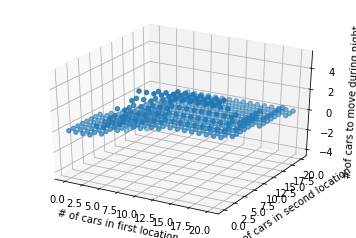

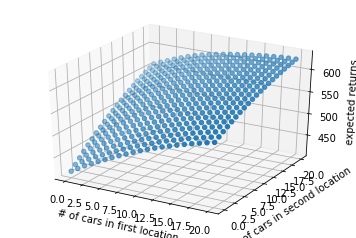

In [75]:
env2 = JacksCarRental()
env2.policy_iteration()
# env2.diffs

In [62]:
np.sum(env2.policies[6] - env2.policies[5])

0.0

In [73]:
env2.policies.keys()

dict_keys([0, 2, 3, 4, 5, 6])

In [ ]:
# maximum # of cars in each location
MAX_CARS = 20

# maximum # of cars to move during night
MAX_MOVE_OF_CARS = 5

# expectation for rental requests in first location
RENTAL_REQUEST_FIRST_LOC = 3

# expectation for rental requests in second location
RENTAL_REQUEST_SECOND_LOC = 4

# expectation for # of cars returned in first location
RETURNS_FIRST_LOC = 3

# expectation for # of cars returned in second location
RETURNS_SECOND_LOC = 2

DISCOUNT = 0.9

# credit earned by a car
RENTAL_CREDIT = 10

# cost of moving a car
MOVE_CAR_COST = 2

# current policy
policy = np.zeros((MAX_CARS + 1, MAX_CARS + 1))

# current state value
stateValue = np.zeros((MAX_CARS + 1, MAX_CARS + 1))

# all possible states
states = []

# all possible actions
actions = np.arange(-MAX_MOVE_OF_CARS, MAX_MOVE_OF_CARS + 1)

# axes for printing use
AxisXPrint = []
AxisYPrint = []
for i in range(0, MAX_CARS + 1):
    for j in range(0, MAX_CARS + 1):
        AxisXPrint.append(i)
        AxisYPrint.append(j)
        states.append([i, j])


# plot a policy/state value matrix
figureIndex = 0
def prettyPrint(data, labels):
    global figureIndex
    fig = plt.figure(figureIndex)
    figureIndex += 1
    ax = fig.add_subplot(111, projection='3d')
    AxisZ = []
    for i, j in states:
        AxisZ.append(data[i, j])
    ax.scatter(AxisXPrint, AxisYPrint, AxisZ)
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])

# An up bound for poisson distribution
# If n is greater than this value, then the probability of getting n is truncated to 0
POISSON_UP_BOUND = 11

# Probability for poisson distribution
# @lam: lambda should be less than 10 for this function
poissonBackup = dict()
def poisson(n, lam):
    global poissonBackup
    key = n * 10 + lam
    if key not in poissonBackup.keys():
        poissonBackup[key] = exp(-lam) * pow(lam, n) / factorial(n)
    return poissonBackup[key]

# @state: [# of cars in first location, # of cars in second location]
# @action: positive if moving cars from first location to second location,
#          negative if moving cars from second location to first location
# @stateValue: state value matrix
def expectedReturn(state, action, stateValue):
    # initailize total return
    returns = 0.0

    # cost for moving cars
    returns -= MOVE_CAR_COST * abs(action)


    # go through all possible rental requests
    for rentalRequestFirstLoc in range(0, POISSON_UP_BOUND):
        for rentalRequestSecondLoc in range(0, POISSON_UP_BOUND):
            # moving cars
            numOfCarsFirstLoc = int(min(state[0] - action, MAX_CARS))
            numOfCarsSecondLoc = int(min(state[1] + action, MAX_CARS))

            # valid rental requests should be less than actual # of cars
            realRentalFirstLoc = min(numOfCarsFirstLoc, rentalRequestFirstLoc)
            realRentalSecondLoc = min(numOfCarsSecondLoc, rentalRequestSecondLoc)

            # get credits for renting
            reward = (realRentalFirstLoc + realRentalSecondLoc) * RENTAL_CREDIT
            numOfCarsFirstLoc -= realRentalFirstLoc
            numOfCarsSecondLoc -= realRentalSecondLoc

            # probability for current combination of rental requests
            prob = poisson(rentalRequestFirstLoc, RENTAL_REQUEST_FIRST_LOC) * \
                         poisson(rentalRequestSecondLoc, RENTAL_REQUEST_SECOND_LOC)

            # if set True, model is simplified such that the # of cars returned in daytime becomes constant
            # rather than a random value from poisson distribution, which will reduce calculation time
            # and leave the optimal policy/value state matrix almost the same
            constantReturnedCars = True
            if constantReturnedCars:
                # get returned cars, those cars can be used for renting tomorrow
                returnedCarsFirstLoc = RETURNS_FIRST_LOC
                returnedCarsSecondLoc = RETURNS_SECOND_LOC
                numOfCarsFirstLoc = min(numOfCarsFirstLoc + returnedCarsFirstLoc, MAX_CARS)
                numOfCarsSecondLoc = min(numOfCarsSecondLoc + returnedCarsSecondLoc, MAX_CARS)
                returns += prob * (reward + DISCOUNT * stateValue[numOfCarsFirstLoc, numOfCarsSecondLoc])
#             else:
#                 numOfCarsFirstLoc_ = numOfCarsFirstLoc
#                 numOfCarsSecondLoc_ = numOfCarsSecondLoc
#                 prob_ = prob
#                 for returnedCarsFirstLoc in range(0, POISSON_UP_BOUND):
#                     for returnedCarsSecondLoc in range(0, POISSON_UP_BOUND):
#                         numOfCarsFirstLoc = numOfCarsFirstLoc_
#                         numOfCarsSecondLoc = numOfCarsSecondLoc_
#                         prob = prob_
#                         numOfCarsFirstLoc = min(numOfCarsFirstLoc + returnedCarsFirstLoc, MAX_CARS)
#                         numOfCarsSecondLoc = min(numOfCarsSecondLoc + returnedCarsSecondLoc, MAX_CARS)
#                         prob = poisson(returnedCarsFirstLoc, RETURNS_FIRST_LOC) * \
#                                poisson(returnedCarsSecondLoc, RETURNS_SECOND_LOC) * prob
#                         returns += prob * (reward + DISCOUNT * stateValue[numOfCarsFirstLoc, numOfCarsSecondLoc])
    return returns







newStateValue = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
improvePolicy = False
policyImprovementInd = 0
policy_eval_index = 0
while True:
    if improvePolicy == True:
        # start policy improvement
        print('Policy improvement', policyImprovementInd)
        policyImprovementInd += 1
        newPolicy = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
        for i, j in states:
            actionReturns = []
            # go through all actions and select the best one
            for action in actions:
                if (action >= 0 and i >= action) or (action < 0 and j >= abs(action)):
                    actionReturns.append(expectedReturn([i, j], action, stateValue))
                else:
                    actionReturns.append(-float('inf'))
            bestAction = np.argmax(actionReturns)
            newPolicy[i, j] = actions[bestAction]

        # if policy is stable
        policyChanges = np.sum(newPolicy != policy)
        print('Policy for', policyChanges, 'states changed')
        if policyChanges == 0:
            policy = newPolicy
            break
        policy = newPolicy
        improvePolicy = False

    # start policy evaluation
    policy_eval_index += 1
    for i, j in states:
        newStateValue[i, j] = expectedReturn([i, j], policy[i, j], stateValue)
    if np.max(np.abs(newStateValue - stateValue)) < 1e-4:
        stateValue[:] = newStateValue
        improvePolicy = True
        continue
    stateValue[:] = newStateValue
prettyPrint(policy, ['# of cars in first location', '# of cars in second location', '# of cars to move during night'])
prettyPrint(stateValue, ['# of cars in first location', '# of cars in second location', 'expected returns'])
plt.show()

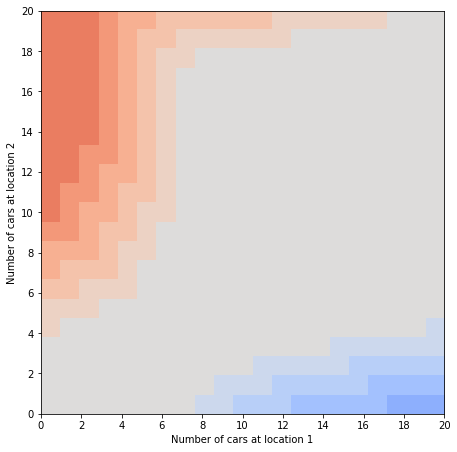

In [87]:
# env2.policy
fig = plt.figure(figsize=(8, 8))

# for i in range(1,5):
ax_image = fig.add_axes([0.1,0.15,0.7,0.7])
ax_color = fig.add_axes([0.85,0.15,0.05,0.7])
image = ax_image.imshow(env2.policies[5][::-1,:], 
                        cmap=cm.coolwarm,
                        extent=[0, 20, 0, 20])
ax_image.set_xticks(np.arange(0,21,2).astype(int))
ax_image.set_yticks(np.arange(0,21,2).astype(int))
ax_image.set_xlabel('Number of cars at location 1')
ax_image.set_ylabel('Number of cars at location 2')
# ax_image.set_title('Policy at different states. Iteration:'+str(iter_idx))
image.set_clim(vmin=-8, vmax=8)
cbar = fig.colorbar(image, cax=ax_color, 
                    ticks=[-5,-4,-3,-2,-1,0,1,2,3,4,5],
                    orientation='vertical')
cbar.remove()
plt.show()
    
    
# fig=plt.figure(figsize=(8, 8))
# columns = 4
# rows = 5
# for i in range(1, columns*rows +1):
#     img = np.random.randint(10, size=(h,w))
#     fig.add_subplot(rows, columns, i)
#     plt.imshow(img)
# plt.show()
    

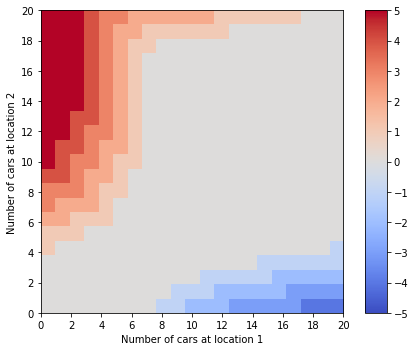

In [50]:
def plot_policy(self):

    fig = plt.figure(figsize=(6,6))
    ax_image = fig.add_axes([0.1,0.15,0.7,0.7])
    ax_color = fig.add_axes([0.85,0.15,0.05,0.7])
    image = ax_image.imshow(self.policy[::-1,:], 
                            cmap=cm.coolwarm,
                            extent=[0, 20, 0, 20])
    ax_image.set_xticks(np.arange(0,21,2).astype(int))
    ax_image.set_yticks(np.arange(0,21,2).astype(int))
    ax_image.set_xlabel('Number of cars at location 1')
    ax_image.set_ylabel('Number of cars at location 2')
    # ax_image.set_title('Policy at different states. Iteration:'+str(iter_idx))
    image.set_clim(vmin=-0, vmax=5)
    cbar = fig.colorbar(image, cax=ax_color, 
                        ticks=[-5,-4,-3,-2,-1,0,1,2,3,4,5],
                        orientation='vertical')
    plt.show()

In [19]:
def policy_iteration(self):
    while True:
        # evaluate policy
        self.policy_evaluation()
        
        # improve policy
        newPolicy = self.policy_improvement()
        
        # if policy is stable
        policyChanges = np.sum(newPolicy != self.policy)
        print('Policy for', policyChanges, 'states changed')
        if policyChanges == 0:
            self.policy = newPolicy
            break
        self.policy = newPolicy
    self.prettyPrint(self.policy, ['# of cars in first location', '# of cars in second location', '# of cars to move during night'])
    self.prettyPrint(self.stateValue, ['# of cars in first location', '# of cars in second location', 'expected returns'])
    plt.show()
    
def policy_improvement(self):
    newPolicy = np.zeros((self.MAX_CARS + 1, self.MAX_CARS + 1))
    for i, j in self.states:
        actionReturns = []
        # go through all actions and select the best one
        for action in self.actions:
            if (action >= 0 and i >= action) or (action < 0 and j >= abs(action)):
                actionReturns.append(self.expectedReturn([i, j], action))
            else:
                actionReturns.append(-float('inf'))
                bestAction = np.argmax(actionReturns)
                newPolicy[i, j] = self.actions[bestAction]            
    return newPolicy
            

def policy_evaluation(self):
    newStateValue = np.zeros((self.MAX_CARS + 1, self.MAX_CARS + 1))
    ##
    delta = 0.0
    ##
    while True:
        for i, j in self.states:
            newStateValue[i, j] = self.expectedReturn([i, j], self.policy[i, j])
            ##
            delta = np.max((delta, np.abs(newStateValue[i,j] - self.stateValue[i, j])))
        ##
        if delta < 1e-4:
#         if np.sum(np.abs(newStateValue - self.stateValue)) < 1e-4:
            self.stateValue[:] = newStateValue
            ##
            break
#             improvePolicy = True
#             continue
    self.stateValue[:] = newStateValue

    
    
#     def policy_iteration(self):
#         newStateValue = np.zeros((self.MAX_CARS + 1, self.MAX_CARS + 1))
#         improvePolicy = False
#         policyImprovementInd = 0
#         policy_eval_index = 0
#         self._state_values = defaultdict()
#         self.diffs = []
#         while True:
# #             if improvePolicy == True:
# #                 break
# #                 # start policy improvement
# #                 print('Policy improvement', policyImprovementInd)
# #                 policyImprovementInd += 1
# #                 newPolicy = np.zeros((self.MAX_CARS + 1, self.MAX_CARS + 1))
# #                 for i, j in self.states:
# #                     actionReturns = []
# #                     # go through all actions and select the best one
# #                     for action in self.actions:
# #                         if (action >= 0 and i >= action) or (action < 0 and j >= abs(action)):
# # #                             actionReturns.append(self.expectedReturn([i, j], action, self.stateValue))
# #                             actionReturns.append(self.expectedReturn([i, j], action))
# #                         else:
# #                             actionReturns.append(-float('inf'))
# #                     bestAction = np.argmax(actionReturns)
# #                     newPolicy[i, j] = self.actions[bestAction]

# #                 # if policy is stable
# #                 policyChanges = np.sum(newPolicy != self.policy)
# #                 print('Policy for', policyChanges, 'states changed')
# #                 if policyChanges == 0:
# #                     self.policy = newPolicy
# #                     break
# #                 self.policy = newPolicy
# #                 improvePolicy = False

#             # start policy evaluation
#             policy_eval_index += 1
#             for i, j in self.states:
# #                 newStateValue[i, j] = self.expectedReturn([i, j], self.policy[i, j], self.stateValue)
#                 newStateValue[i, j] = self.expectedReturn([i, j], self.policy[i, j])
# #             if np.sum(np.abs(newStateValue - self.stateValue)) < 1e-4:
#             self.diffs.append(np.max(np.abs(newStateValue - self.stateValue)))
#             if np.max(np.abs(newStateValue - self.stateValue)) < 1e-4:
#                 break
# #                 self.stateValue[:] = newStateValue
# #                 improvePolicy = True
# #                 continue
#             self.stateValue[:] = newStateValue
#             self._state_values[policy_eval_index] = newStateValue
            

#         self.prettyPrint(self.policy, ['# of cars in first location', '# of cars in second location', '# of cars to move during night'])
#         self.prettyPrint(self.stateValue, ['# of cars in first location', '# of cars in second location', 'expected returns'])
#         plt.show()
